In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\domma\Dropbox\Software\CognitiveModels\content"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


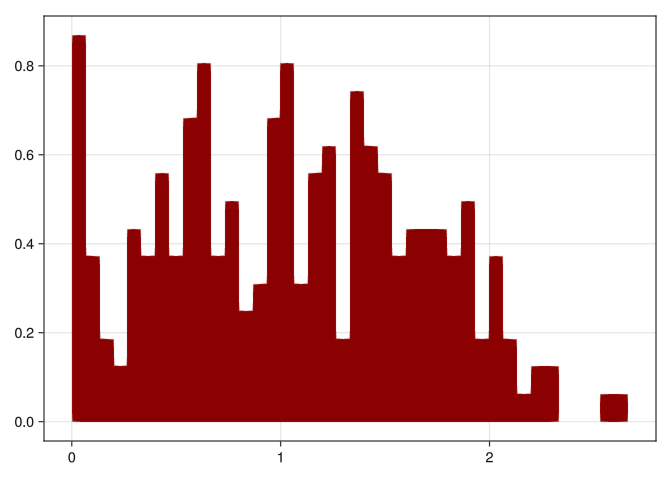

In [2]:
#| code-fold: false

using Downloads, CSV, DataFrames, Random
using Turing, Distributions, SequentialSamplingModels
using GLMakie

Random.seed!(123)  # For reproducibility

df = CSV.read(Downloads.download("https://raw.githubusercontent.com/DominiqueMakowski/CognitiveModels/main/data/makowski2023.csv"), DataFrame)

# Show 10 first rows
first(df, 10)

# Plot the distribution of "Disinhibition"
hist(df.Disinhibition, normalization = :pdf, color=:darkred, bins=40)

In [3]:
#| code-fold: false
#| output: false

@model function model_Gaussian(x)

    # Priors
    σ ~ truncated(Normal(0, 1); lower=0)  # Strictly positive half normal distribution
    μ ~ Normal(0, 3)

    # Iterate through every observation
    for i in 1:length(x)
        # Likelihood family
        x[i] ~ Normal(μ, σ)
    end
end

# Fit the model with the data
fit_Gaussian = model_Gaussian(df.Disinhibition)
# Sample results using MCMC
chain_Gaussian = sample(fit_Gaussian, NUTS(), 400)

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling:   0%|█                                        |  ETA: 0:00:36

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (400×14×1 Array{Float64, 3}):

Iterations        = 201:1:600
Number of chains  = 1
Samples per chain = 400
Wall duration     = 7.78 seconds
Compute duration  = 7.78 seconds
parameters        = σ, μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           σ    0.6184    0.0268    0.0010   682.6762   333.3517    0.9995     ⋯
           μ    1.0658    0.0404    0.0019   452.7758   306.4634    0.9993     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ  

In [4]:
println("Mean of the data: $(round(mean(df.Disinhibition); digits=3)) vs. mean from the model: $(round(mean(chain_Gaussian[:μ]); digits=3))")
println("SD of the data: $(round(std(df.Disinhibition); digits=3)) vs. SD from the model: $(round(mean(chain_Gaussian[:σ]); digits=3))")

Mean of the data: 1.064 vs. mean from the model: 1.066
SD of the data: 0.616 vs. SD from the model: 0.618


In [5]:
#| output: false

pred = predict(model_Gaussian([(missing) for i in 1:length(df.Disinhibition)]), chain_Gaussian)
pred = Array(pred)

400×242 Matrix{Float64}:
  0.588856   1.33487     0.912075  …  0.206602   0.654613   0.570301
  1.41814    0.50494     1.04911      1.66473    1.61657    0.828262
  0.997178   1.49207     1.7789       0.909917   1.61463    0.946746
  2.10443    1.58862     2.35616      0.881057   1.72976    0.316686
  1.47772   -0.448441    1.16062      0.788135   0.861952   2.08903
  0.775693   0.734704    1.45471   …  1.02711    1.42119    1.94279
  1.0388     0.330248    1.46427      1.5174     0.941951   0.371055
  0.481663   0.291409    0.712276     1.43467    0.599912   0.917276
  1.21969    1.36735    -0.54655      0.249907   1.11926    1.29994
  0.494441   0.661483    1.05337      1.46298    1.77276    2.24813
  1.11629    0.874553    0.324196  …  0.540746   0.596365   2.51126
  2.31524    1.28507     0.623688     0.500101   1.40501    2.77729
  1.04183    2.19055     2.32678      0.611083   0.200383   2.04246
  ⋮                                ⋱             ⋮         
  1.8753     1.48615    -

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


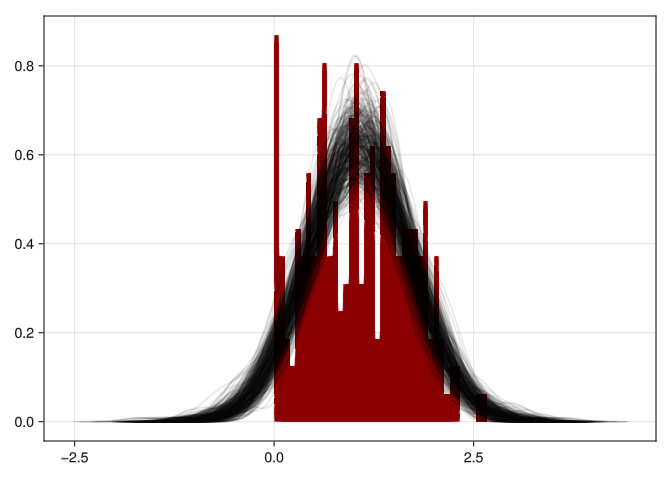

In [6]:
fig = hist(df.Disinhibition, normalization = :pdf, color=:darkred, bins=40)
for i in 1:length(chain_Gaussian)
    lines!(Makie.KernelDensity.kde(pred[i, :]), alpha=0.1, color=:black)
end
fig

In [7]:
#| code-fold: false
#| output: false

function data_rescale(x; old_range=[minimum(x), maximum(x)], new_range=[0, 1])
    return (x .- old_range[1]) ./ (old_range[2] - old_range[1]) .* (new_range[2] - new_range[1]) .+ new_range[1]
end

# Rescale the variable
df.Disinhibition2 = data_rescale(df.Disinhibition; old_range=[0, 3], new_range=[0, 1])

242-element Vector{Float64}:
 0.014
 0.456
 0.414
 0.15
 0.204
 0.236
 0.014
 0.5
 0.408
 0.308
 0.38799999999999996
 0.148
 0.19399999999999998
 ⋮
 0.026
 0.62
 0.18400000000000002
 0.484
 0.586
 0.448
 0.104
 0.22
 0.023999999999999997
 0.41
 0.40599999999999997
 0.536

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


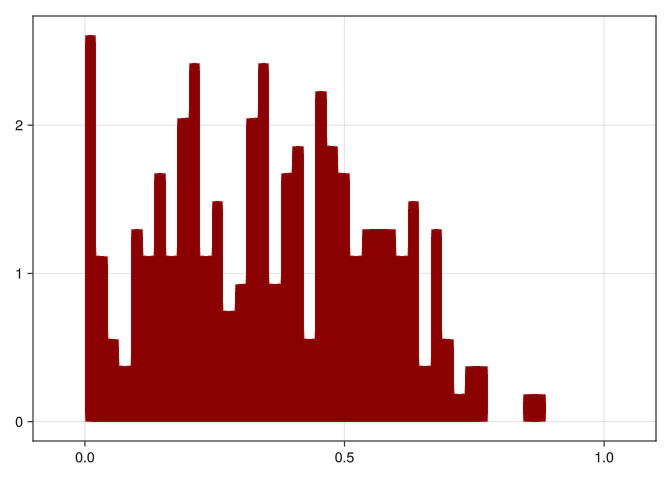

In [8]:
# Visualize
fig = hist(df.Disinhibition2, normalization = :pdf, color=:darkred, bins=40)
xlims!(-0.1, 1.1)
fig

In [9]:
#| code-fold: false

function BetaMuPhi(μ, ϕ)
    return Beta(μ * ϕ, (1 - μ) * ϕ)
end

BetaMuPhi (generic function with 1 method)

In [10]:
#| code-fold: false
#| output: false

df.Disinhibition3 = data_rescale(df.Disinhibition; old_range=[0, 3], new_range=[eps(), 1 - eps()])

242-element Vector{Float64}:
 0.014000000000000215
 0.456
 0.41400000000000003
 0.15000000000000016
 0.20400000000000013
 0.2360000000000001
 0.014000000000000215
 0.5
 0.40800000000000003
 0.3080000000000001
 0.388
 0.14800000000000016
 0.19400000000000012
 ⋮
 0.02600000000000021
 0.62
 0.18400000000000016
 0.484
 0.586
 0.448
 0.10400000000000018
 0.2200000000000001
 0.02400000000000021
 0.41000000000000003
 0.406
 0.536

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


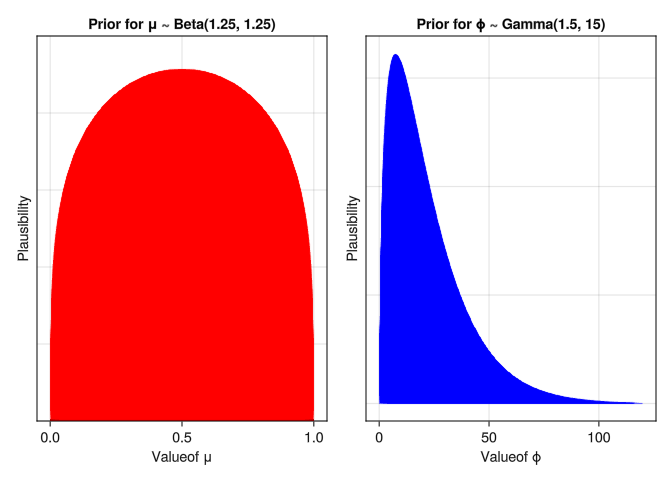

In [11]:
fig = Figure()
ax1 = Axis(fig[1, 1], xlabel="Valueof μ", ylabel="Plausibility", title="Prior for μ ~ Beta(1.25, 1.25)", yticksvisible=false, yticklabelsvisible=false,)
band!(ax1, range(0, 1, length=1000), 0, pdf.(Beta(1.25, 1.25), range(0, 1, length=1000)), color=:red)
ylims!(0, 1.25)
ax1 = Axis(fig[1, 2], xlabel="Valueof ϕ", ylabel="Plausibility", title="Prior for ϕ ~ Gamma(1.5, 15)", yticksvisible=false, yticklabelsvisible=false,)
band!(ax1, range(0, 120, length=1000), 0, pdf.(Gamma(1.5, 15), range(0, 120, length=1000)), color=:blue)
# ylims!(0, 0.06)
fig

In [12]:
#| code-fold: false
#| output: false

@model function model_Beta(x)
    μ ~ Beta(1.25, 1.25)
    ϕ ~ Gamma(1.5, 15)
    
    for i in 1:length(x)
        x[i] ~ BetaMuPhi(μ, ϕ)
    end
end

fit_Beta = model_Beta(df.Disinhibition3)
chain_Beta = sample(fit_Beta, NUTS(), 500)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling:  53%|██████████████████████                   |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (500×14×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 3.36 seconds
Compute duration  = 3.36 seconds
parameters        = μ, ϕ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           μ    0.2753    0.0164    0.0008   395.5004   335.4254    1.0006     ⋯
           ϕ    1.3739    0.1142    0.0060   366.1499   291.5972    1.0221     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           μ  

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


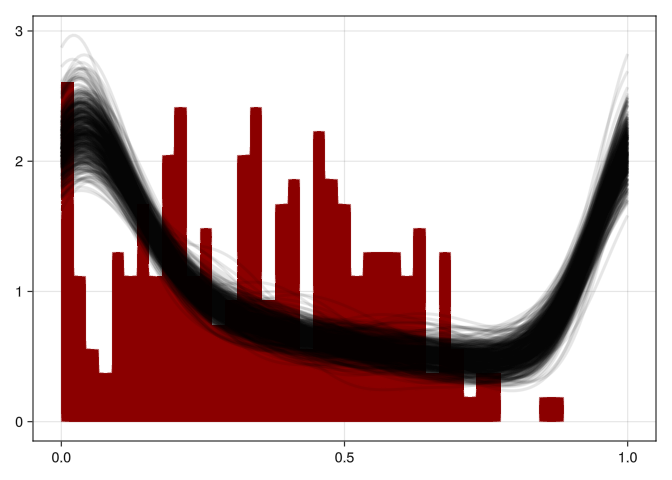

In [13]:
pred = predict(model_Beta([(missing) for i in 1:nrow(df)]), chain_Beta)
pred = Array(pred)

fig = hist(df.Disinhibition3, normalization = :pdf, color=:darkred, bins=40)
for i in 1:length(chain_Beta)
    density!(pred[i, :], color=(:black, 0), strokecolor = (:black, 0.1), strokewidth = 3, boundary=(0, 1))
end
fig

In [14]:
#| code-fold: false
#| output: false

# Filter out extreme values
var_noextreme = df.Disinhibition2[(df.Disinhibition2 .> 0) .& (df.Disinhibition2 .< 1)]

# Refit
fit_Beta = model_Beta(var_noextreme)
chain_Beta = sample(fit_Beta, NUTS(), 500)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling:  85%|███████████████████████████████████      |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (500×14×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 0.14 seconds
Compute duration  = 0.14 seconds
parameters        = μ, ϕ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           μ    0.3642    0.0132    0.0006   546.6956   290.1046    0.9986     ⋯
           ϕ    4.8034    0.4220    0.0169   639.6461   400.7875    0.9993     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           μ  

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


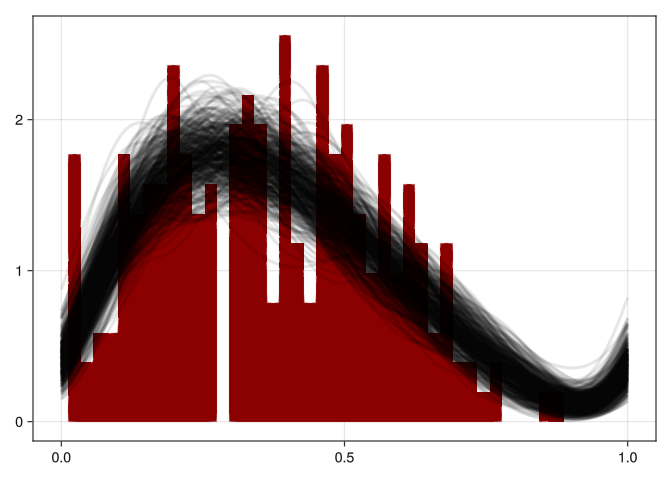

In [15]:
pred = predict(model_Beta([(missing) for i in 1:length(var_noextreme)]), chain_Beta)
pred = Array(pred)

fig = hist(var_noextreme, normalization = :pdf, color=:darkred, bins=40)
for i in 1:length(chain_Beta)
    density!(pred[i, :], color=(:black, 0), strokecolor = (:black, 0.1), strokewidth = 3, boundary=(0, 1))
end
fig